In [29]:
# !pip install numpy
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

from sklearn.metrics import root_mean_squared_error

In [ ]:
# !pip install pyarrow
# # !pip uninstall numpy

# !pip install numpy==1.26.4
# import numpy as np
# np.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 78.1 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
# pd.__version__

In [11]:
filename = 'green_tripdata_2024-01'
df = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/{filename}.parquet')
df.to_parquet(f'./data/{filename}.parquet')

print(df.shape[0])
df.head()

56551


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56551 entries, 0 to 56550
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56551 non-null  int32         
 1   lpep_pickup_datetime   56551 non-null  datetime64[us]
 2   lpep_dropoff_datetime  56551 non-null  datetime64[us]
 3   store_and_fwd_flag     53136 non-null  object        
 4   RatecodeID             53136 non-null  float64       
 5   PULocationID           56551 non-null  int32         
 6   DOLocationID           56551 non-null  int32         
 7   passenger_count        53136 non-null  float64       
 8   trip_distance          56551 non-null  float64       
 9   fare_amount            56551 non-null  float64       
 10  extra                  56551 non-null  float64       
 11  mta_tax                56551 non-null  float64       
 12  tip_amount             56551 non-null  float64       
 13  t

In [14]:
df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']) 
df['duration'] = df.duration.apply(lambda t: t.total_seconds() / 60) # in minutes
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [18]:
categorical_var = ['PULocationID', 'DOLocationID']
numerical_var = ['trip_distance']

df[categorical_var] = df[categorical_var].astype(str)
df['PU_DO'] = df.PULocationID + "_" + df.DOLocationID

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000,236_239
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667,65_170
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333,74_262
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667,74_116
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333,74_243


In [20]:
train_dict = df[categorical_var + numerical_var].to_dict(orient='records')

dv = DictVectorizer()

target = 'duration'

X_train = dv.fit_transform(train_dict)
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f"root mean squared error is: {root_mean_squared_error(y_train, y_pred)}")

root mean squared error is: 7.1228222122750955


/tmp/ipykernel_4129/4258851784.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_4129/4258851784.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='target')


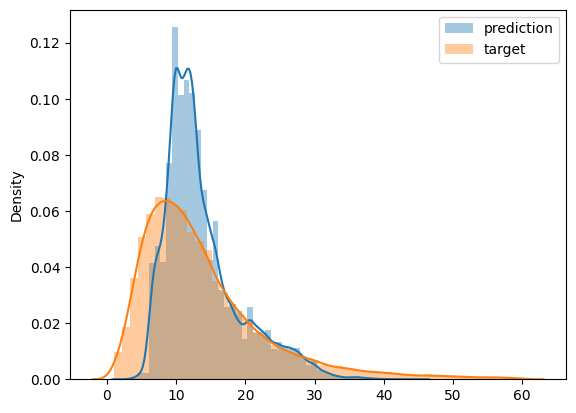

In [21]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='target')

plt.legend()

In [23]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    df['PU_DO'] = df.PULocationID + "_" + df.DOLocationID
    
    return df

In [24]:
df_train = read_dataframe('./data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2024-02.parquet')

print(df_train.shape[0], df_val.shape[0])

54373 51497


In [ ]:
categorical = ['PU_DO', 'PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

pipeline = make_pipeline(
    DictVectorizer(),
    LinearRegression()
)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_train = df_train[target].values
y_val = df_val[target].values

In [49]:
pipeline.fit(train_dict, y_train)
y_pred = pipeline.predict(val_dicts)

print(f"root mean squared error is: {root_mean_squared_error(y_val, y_pred)}")

root mean squared error is: 7.265835798459329


In [50]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump(pipeline, f_out)

In [ ]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_val)

# print(f"root mean squared error is: {root_mean_squared_error(y_val, y_pred)}")

root mean squared error is: 5.995041447869019


In [ ]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)